In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

# Dataset

In [2]:
df = pd.read_csv(
    'cansim-0800020-eng-6674700030567901031.csv',
    skiprows=6, skipfooter=9, engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


### Adjust date

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


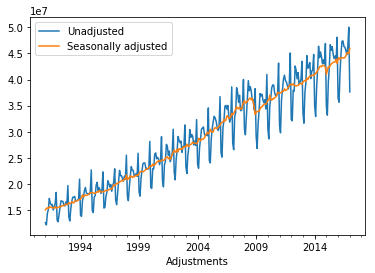

In [3]:
from pandas.tseries.offsets import MonthEnd

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')

display(df.head())
display(df.plot())

### Split train-testset

In [4]:
split_date = pd.Timestamp('01-01-2011')

train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

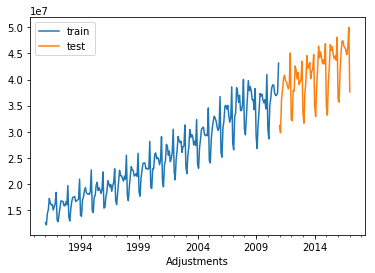

In [5]:
ax = train.plot();
test.plot(ax=ax)
plt.legend(['train', 'test']);

#### MinMax Scaling input

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

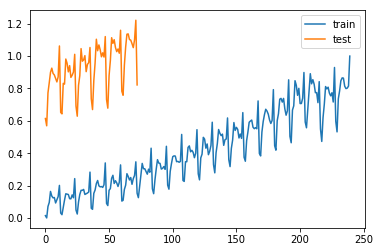

In [7]:
ax = pd.DataFrame(train_sc).plot();
pd.DataFrame(test_sc).plot(ax=ax)
plt.legend(['train', 'test']);

#### Define train-testset 

In [8]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

print(X_train.shape)
print(y_train.shape)
print('')
print(X_test.shape)
print(y_test.shape)

(239, 1)
(239, 1)

(72, 1)
(72, 1)


# Models

## Fully connected

In [9]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()

model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=200,batch_size=2,
    validation_split=0.25,
    verbose=0, callbacks=[early_stop])

Epoch 00009: early stopping


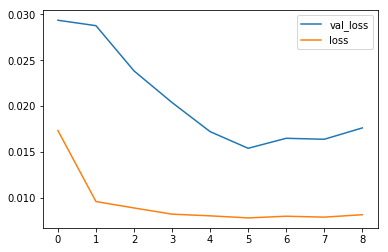

In [12]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

#### Evaluate

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error as mse

print("The Mean Squared Error on the Train set is:\t{:0.5f}".format(mse(y_train, y_train_pred)))
print("The Mean Squared Error on the Test set is:\t{:0.5f}".format(mse(y_test, y_test_pred)))

The Mean Squared Error on the Train set is:	0.01023
The Mean Squared Error on the Test set is:	0.02377


In [15]:
from sklearn.metrics import r2_score

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.822
The R2 score on the Test set is:	-0.141


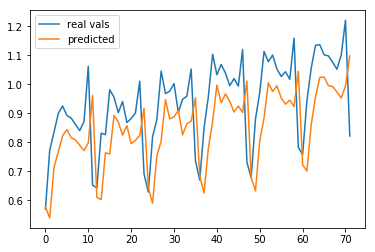

In [16]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['real vals', 'predicted']);

## LSTM

In [17]:
# Convert to tensor: (batch_size, timesteps, input_dim)
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

print(X_train_t.shape)
print(X_test_t.shape)

(239, 1, 1)
(72, 1, 1)


In [18]:
from keras.models import Sequential
import keras.backend as K
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [20]:
history = model.fit(
    X_train_t, y_train,
    epochs=100, batch_size=1, verbose=0,
    validation_split=0.25,
    callbacks=[early_stop])

Epoch 00018: early stopping


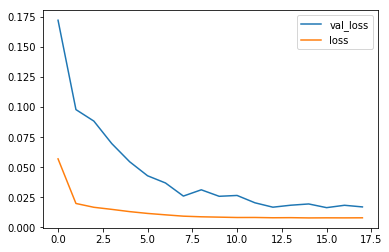

In [21]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

#### Evaluate

In [22]:
y_train_pred = model.predict(X_train_t)
y_test_pred = model.predict(X_test_t)

In [23]:
from sklearn.metrics import mean_squared_error as mse

print("The Mean Squared Error on the Train set is:\t{:0.5f}".format(mse(y_train, y_train_pred)))
print("The Mean Squared Error on the Test set is:\t{:0.5f}".format(mse(y_test, y_test_pred)))

The Mean Squared Error on the Train set is:	0.01008
The Mean Squared Error on the Test set is:	0.02530


In [24]:
from sklearn.metrics import r2_score

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	0.824
The R2 score on the Test set is:	-0.214


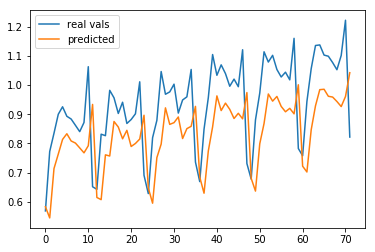

In [25]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.legend(['real vals', 'predicted']);

## => The models are not good R2 scores < 0 for testset